## Semantic segmentation model

The project was created to train and deploy the simple semantic segmentatin model that solves the Airbus Ship Detection Challenge from kaggle. The dataset is available via the [link](https://www.kaggle.com/competitions/airbus-ship-detection/data). 

All the model's parameters will be in the config.json file, so we need to import it directly to the working environment. 

In [9]:
import json

with open('config.json', 'r') as f:
    CONFIG = json.load(f)

### Importing the main libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### EDA

The first step is to do simple EDA on our dataset. Let's take a look at the images directly to their sizes, channels and extensions.


found 192556 images.
Using 6 threads. (max:6)



100%|██████████| 192556/192556 [2:10:44<00:00, 24.55it/s]  



*--------------------------------------------------------------------------------------*
number of images                         |  192556

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  768
max height                               |  768
mean height                              |  768.0
median height                            |  768

min width                                |  768
max width                                |  768
mean width                               |  768.0
median width                             |  768

mean height/width ratio                  |  1.0
median height/width ratio                |  1.0
recommended input size(by mean)          |  [768 768] (h x w, multiples of 8)
recommended input size(by mean)          |  [768 768] (h x w, multiples of 16)
recommended input size(by mean)          |  [768 768] (h x w, mu

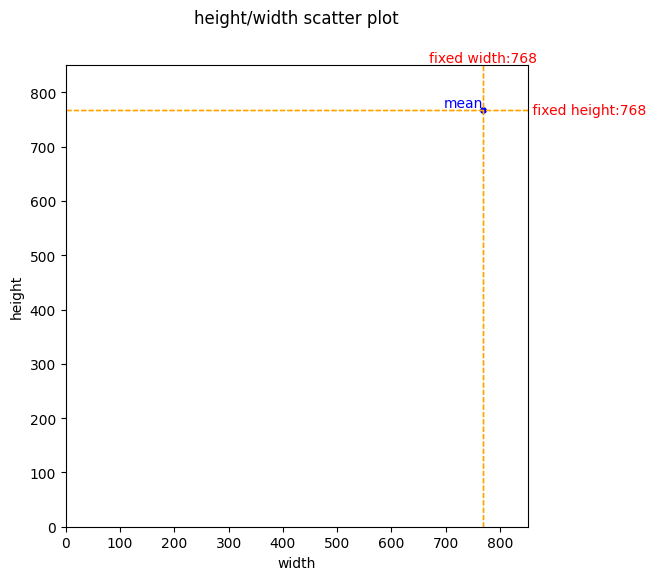

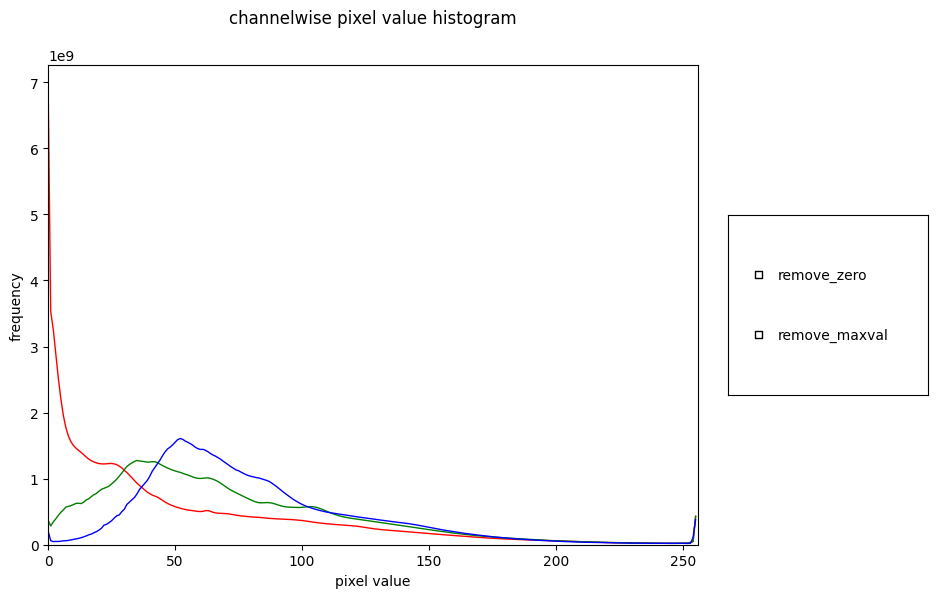

{'dtype': 'uint8',
 'channels': [3],
 'extensions': ['jpg'],
 'min_h': 768,
 'max_h': 768,
 'mean_h': 768.0,
 'median_h': 768,
 'min_w': 768,
 'max_w': 768,
 'mean_w': 768.0,
 'median_w': 768,
 'mean_hw_ratio': 1.0,
 'median_hw_ratio': 1.0,
 'rec_hw_size_8': array([768, 768]),
 'rec_hw_size_16': array([768, 768]),
 'rec_hw_size_32': array([768, 768]),
 'mean': array([0.20201763, 0.28139036, 0.31798357]),
 'std': array([0.20949488, 0.19001535, 0.16820381])}

In [2]:
from basic_image_eda import BasicImageEDA

BasicImageEDA.explore(CONFIG['dirs']['data_imgs'], dimension_plot=True, channel_hist=True)

We can see, that this dataset consists only of 768x768 .jpg images and the dominant colors of each picture are green and blue. That is pretty logical due to the fact that dataset includes marine satellite images.

In [3]:
images = os.listdir(CONFIG['dirs']['data_imgs'])
images.sort()

In [4]:
print(f'The total number of images is: {len(images)}')

The total number of images is: 192556


In [5]:
print(f'These images are represented as jpg file and look like this: {images[:5]}')

These images are represented as jpg file and look like this: ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg', '000194a2d.jpg', '0001b1832.jpg']


In [6]:
masks_rles = pd.read_csv(CONFIG['dirs']['rle_codes'])
masks_rles.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [7]:
masks_rles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


As we can see there are more ids in this dataframe than actual images, it's because some images have several boats on them so they have several entities in this dataframe. Now let's check the distribution of boats

In [8]:
masks_rles['ships'] = masks_rles['EncodedPixels'].apply(lambda row: 1 if isinstance(row, str) else 0)
masks_rles.head()

,ImageId,EncodedPixels,ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1


In [9]:
unique_ids = masks_rles.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_ids.head()

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


In [10]:
unique_ids['has_ships'] = unique_ids['ships'].apply(lambda s_count: 1 if s_count > 0 else 0)
unique_ids

,ImageId,ships,has_ships
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,1,1
3,000194a2d.jpg,5,1
4,0001b1832.jpg,0,0
...,...,...,...
192551,fffedbb6b.jpg,0,0
192552,ffff2aa57.jpg,0,0
192553,ffff6e525.jpg,0,0
192554,ffffc50b4.jpg,0,0


<Axes: title={'center': 'Images with/without boats'}, xlabel='has_ships', ylabel='count'>

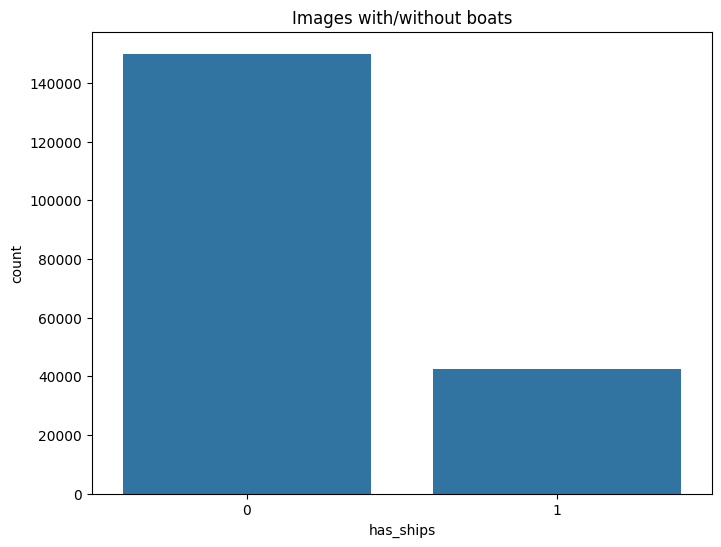

In [11]:
fig = plt.figure(figsize=(8,6))
plt.title('Images with/without boats')
sns.barplot(unique_ids.has_ships.value_counts())

<Axes: title={'center': 'Boats distribution'}, xlabel='ships', ylabel='Count'>

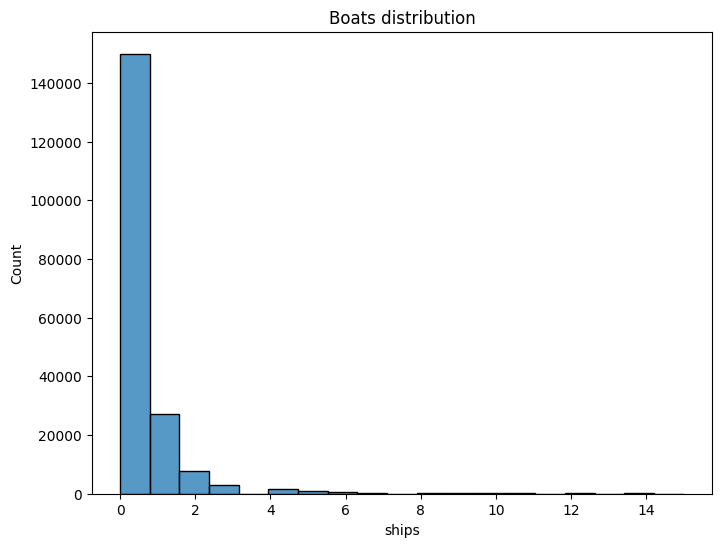

In [12]:
fig = plt.figure(figsize=(8,6))
plt.title('Boats distribution')
sns.histplot(data=unique_ids.ships)

Most part of the dataset consists of satellite images that doesn't have any boats and other part mostly consists of images that have from 1 to 5 boats.

### Preparing some help functions for dencoding the RLEs and represent them as images

In [13]:
def rle_decode(mask, shape=(768, 768)):
    '''
    Function was created to decode RLE of ONE ship into the numpy array
    Arguments:
        mask: Mask of one ship in str format
        shape: Output shape of the image
    '''
    starts, lengths = [np.asarray(x, dtype=int) for x in (mask.split()[0::2], mask.split()[1::2])]
    ends = starts + lengths - 1

    output_msk = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for low, high in zip(starts, ends):
        output_msk[low:high+1] = 1

    # Returns the transposed mask array that contains 1s and 0s. 1 - ship, 0 - background
    return output_msk.reshape(shape).T

def masks_as_image(msk_list):
    '''
    Function was created to create an image based on the mask list provided
    Arguments:
        msk_list: List of masks for each ship
    '''
    output_img = np.zeros((768, 768), dtype=np.int16)
    for mask in msk_list:
        if isinstance(mask, str):
            output_img += rle_decode(mask)
    
    # Returns the full mask that contains all ships on image
    return np.expand_dims(output_img, -1)

Let's take a look on how this actually works.
To do this we need to choose the image that has several ships, for instance it can be __'000194a2d.jpg'__

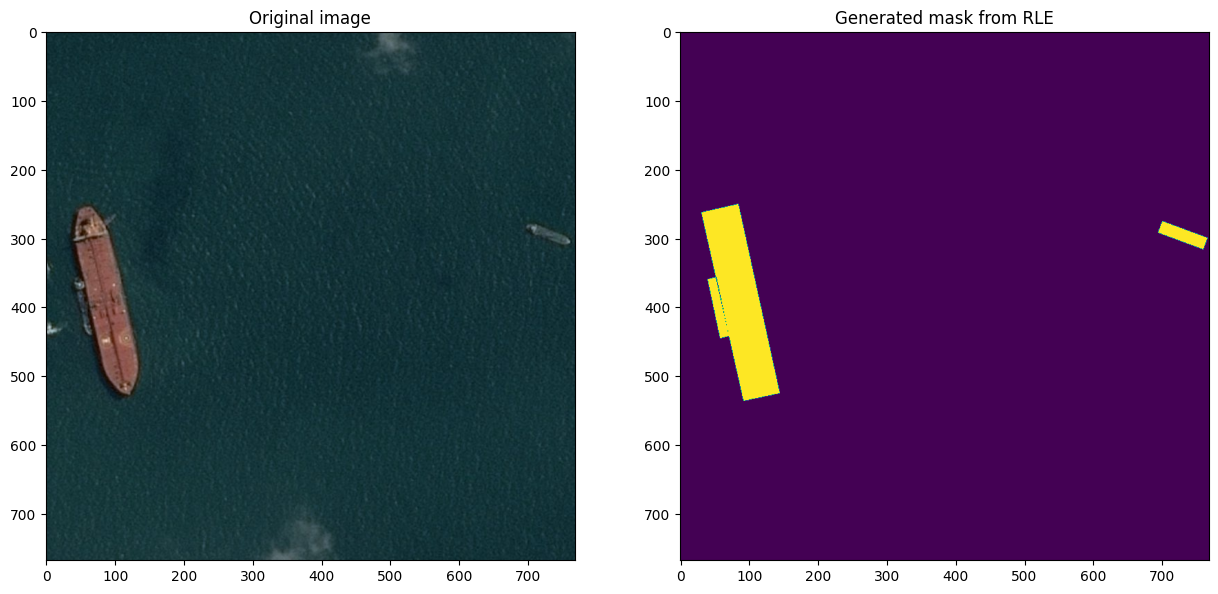

In [14]:
from skimage.io import imread

test_img = '1c670582a.jpg'
original = imread(CONFIG['dirs']['data_imgs'] + '/' + test_img)

for id, masks in list(masks_rles.groupby('ImageId')):
    if id == test_img:
        plt.figure(figsize=(15,8))
        plt.subplot(121)
        plt.title('Original image')
        plt.imshow(original)
        plt.subplot(122)
        plt.title('Generated mask from RLE')
        plt.imshow(masks_as_image(masks['EncodedPixels'].values))
        break

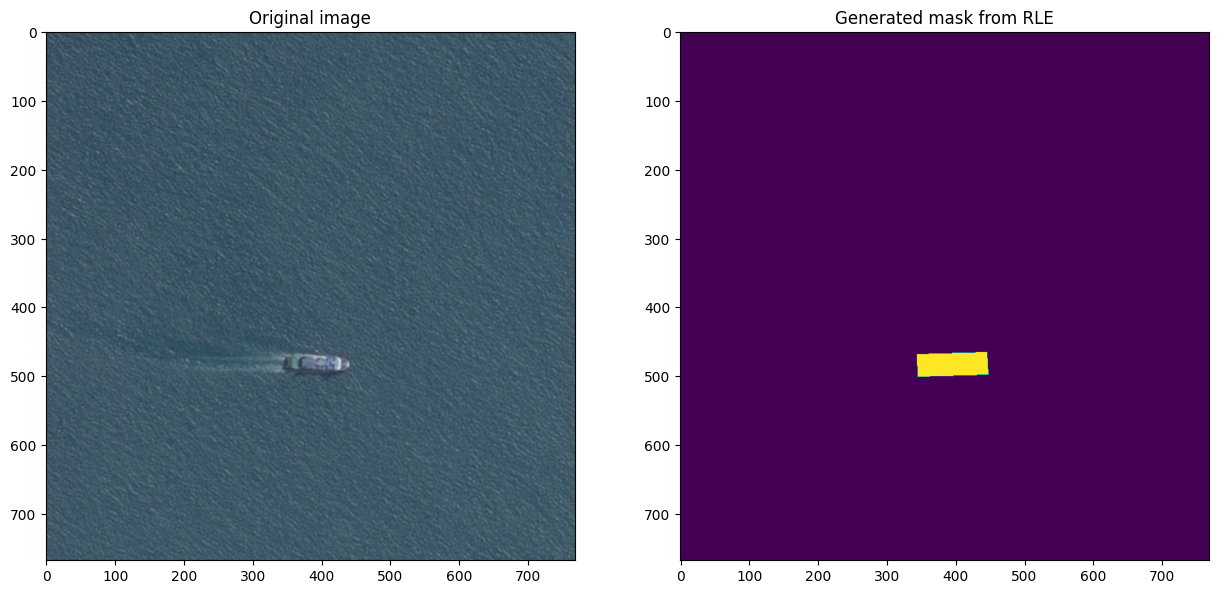

In [15]:
test_img = '000155de5.jpg'
original = imread(CONFIG['dirs']['data_imgs'] + '/' + test_img)

for id, masks in list(masks_rles.groupby('ImageId')):
    if id == test_img:
        plt.figure(figsize=(15,8))
        plt.subplot(121)
        plt.title('Original image')
        plt.imshow(original)
        plt.subplot(122)
        plt.title('Generated mask from RLE')
        plt.imshow(masks_as_image(masks['EncodedPixels'].values))
        break

### Preparing the train and test data for modeling

In [16]:
masks_rles.drop(['ships'], axis=1, inplace=True)

As this dataset is pretty big, and I don't have enough computing power and time on my machine, I will decrease the size of the dataset to make solve this problem faster

In [141]:
decreased_unique_ids = unique_ids.sample(3500).reset_index(drop=True)

(array([3.209e+03, 1.370e+02, 8.800e+01, 2.000e+01, 2.400e+01, 4.000e+00,
        4.000e+00, 3.000e+00, 7.000e+00, 4.000e+00]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

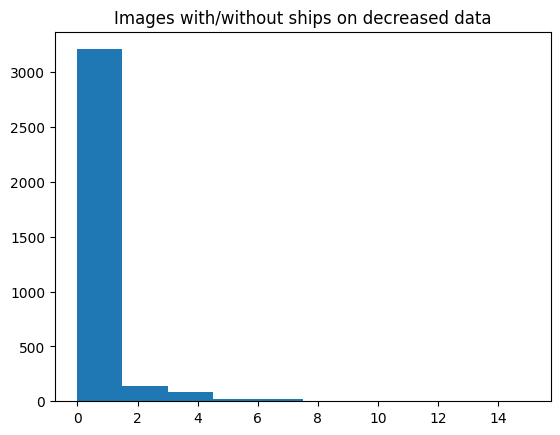

In [142]:
plt.title('Images with/without ships on decreased data')
plt.hist(decreased_unique_ids.ships)

In [143]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(decreased_unique_ids, test_size=.1)

In [144]:
train_df = pd.merge(masks_rles, train_ids)
test_df = pd.merge(masks_rles, test_ids)

In [145]:
print(f'Eventually we have {len(train_df)} train masks and {len(test_df)} test masks')

Eventually we have 3860 train masks and 413 test masks


In [146]:
def create_image_gen(df, batch_size=CONFIG['model']['batch_size']):
    batches = list(df.groupby('ImageId'))
    out_img = []
    out_mask = []

    while True:
        np.random.shuffle(batches)
        for id, masks in batches:
            rgb_path = os.path.join(CONFIG['dirs']['data_imgs'], id)
            img = imread(rgb_path)
            final_mask = masks_as_image(masks['EncodedPixels'].values)

            out_img += [img]
            out_mask += [final_mask]
            if len(out_img) >= batch_size:
                yield np.stack(out_img, dtype='float32')/255.0, np.stack(out_mask, dtype='float32')
                out_img, out_mask = [], []

In [147]:
train_gen = create_image_gen(train_df)

train_x, train_y = next(train_gen)
print(f"Train X:\nShape: {train_x.shape}\nMin value: {train_x.min()}\nMax value: {train_x.max()}")
print(f"\nTrain Y:\nShape: {train_y.shape}\nMin value: {train_y.min()}\nMax value: {train_y.max()}")

Train X:
Shape: (2, 768, 768, 3)
Min value: 0.0
Max value: 0.8470588326454163

Train Y:
Shape: (2, 768, 768, 1)
Min value: 0.0
Max value: 0.0


In [148]:
from keras.preprocessing.image import ImageDataGenerator

dg_args = {
    'rotation_range': 15, # Range for random rotations
    'horizontal_flip': True, # Random horizonral flipping
    'vertical_flip': True, # Random vertical flipping
    'data_format': "channels_last" # Means that the shape is represented like: (batch, height, width, channels)
}

image_gen = ImageDataGenerator(**dg_args)
masks_gen = ImageDataGenerator(**dg_args)

In [149]:
def augmented_data_gen(gen):
    for x, y in gen:
        seed = 56 # The seed should be the same for images and masks

        gx = image_gen.flow(255*x, batch_size=x.shape[0], seed=seed)
        gy = image_gen.flow(y, batch_size=y.shape[0], seed=seed)

        yield next(gx)/255.0, next(gy)

In [150]:
train_data_gen = augmented_data_gen(train_gen)
x, y = next(train_data_gen)
print('X:', x.shape, x.dtype, x.min(), x.max())
print('Y:', y.shape, y.dtype, y.min(), y.max())

X: (2, 768, 768, 3) float32 0.0 0.7968852
Y: (2, 768, 768, 1) float32 0.0 0.0


Reset all generators

In [151]:
train_data_gen = augmented_data_gen(create_image_gen(train_df))
test_data_gen = create_image_gen(test_df)

### Creating the U-net architecture

In order to implement the U-net architecture we need to define two stages of our model:
- Encoder block - used to extract the useful features from an image
- Decoder block - using the skip connections from encoder layers, upsample the output to create a mask

In [11]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, BatchNormalization, Activation, Concatenate, Input, GaussianNoise

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)

    return x, p

def decoder_block(inputs, skip_connection, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip_connection])
    x = conv_block(x, num_filters)

    return x

In [12]:
def build_unet(input_shape):
    inputs = Input(input_shape)
    inputs = GaussianNoise(CONFIG['model']['gaussian_noise'])(inputs)

    """Encoder block"""
    skip_1, p1 = encoder_block(inputs, 8)
    skip_2, p2 = encoder_block(p1, 16)
    skip_3, p3 = encoder_block(p2, 32)
    skip_4, p4 = encoder_block(p3, 64)

    """Bridge"""
    b1 = conv_block(p4, 128)

    """Decoder"""
    d1 = decoder_block(b1, skip_4, 64)
    d2 = decoder_block(d1, skip_3, 32)
    d3 = decoder_block(d2, skip_2, 16)
    d4 = decoder_block(d3, skip_1, 8)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)
    model = Model(inputs, outputs, name="U-NET")

    return model

In [154]:
model = build_unet((768, 768, 3))
model.summary()

Model: "U-NET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 conv2d_133 (Conv2D)         (None, 768, 768, 8)          224       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_126 (B  (None, 768, 768, 8)          32        ['conv2d_133[1][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_126 (Activation  (None, 768, 768, 8)          0         ['batch_normalization_126[

Now let's define some additional parameters for a model training

To measure the performance of the model, we'll use the Dice score and dice coefficient loss for model training.

In [15]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """The dice coefficient formula is: 2*|A∩B|/|A|+|B|"""

    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    """The dice coefficient loss is just the reverse of the dice coefficient"""

    return 1-dice_coef(y_true, y_pred)

In [156]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import Adam

opt = Adam(learning_rate=CONFIG['model']['lr'])
callbacks = [
    ModelCheckpoint(CONFIG['dirs']['model_weights'], verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    CSVLogger(CONFIG['dirs']['model_logs']),
    EarlyStopping(monitor='val_loss', patience=20)
]

model.compile(loss=dice_coef_loss, optimizer=opt, metrics=[dice_coef])

In [157]:
model.fit_generator(
    train_data_gen, 
    steps_per_epoch=len(train_df) // CONFIG['model']['batch_size'],
    validation_steps=len(test_df) // CONFIG['model']['batch_size'],
    epochs=CONFIG['model']['epochs'],
    callbacks=callbacks,
    validation_data=test_data_gen,
    verbose=1
)

C:\Users\Артур\AppData\Local\Temp\ipykernel_8480\2632921743.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
1930/1930 [==============================] - ETA: 0s - loss: 0.5815 - dice_coef: 0.4185
Epoch 1: saving model to model.weights.h5
1930/1930 [==============================] - 2717s 1s/step - loss: 0.5815 - dice_coef: 0.4185 - val_loss: 0.3338 - val_dice_coef: 0.6662 - lr: 0.0100
Epoch 2/50


d:\Coding\DataScience\Projects\SegmentationModel\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1930/1930 [==============================] - ETA: 0s - loss: 0.3925 - dice_coef: 0.6075
Epoch 2: saving model to model.weights.h5
1930/1930 [==============================] - 2214s 1s/step - loss: 0.3925 - dice_coef: 0.6075 - val_loss: 0.4061 - val_dice_coef: 0.5939 - lr: 0.0100
Epoch 3/50
1930/1930 [==============================] - ETA: 0s - loss: 0.3916 - dice_coef: 0.6084
Epoch 3: saving model to model.weights.h5
1930/1930 [==============================] - 2159s 1s/step - loss: 0.3916 - dice_coef: 0.6084 - val_loss: 0.3679 - val_dice_coef: 0.6321 - lr: 0.0100
Epoch 4/50
1930/1930 [==============================] - ETA: 0s - loss: 0.3945 - dice_coef: 0.6055
Epoch 4: saving model to model.weights.h5
1930/1930 [==============================] - 2164s 1s/step - loss: 0.3945 - dice_coef: 0.6055 - val_loss: 0.3674 - val_dice_coef: 0.6326 - lr: 0.0100
Epoch 5/50
1930/1930 [==============================] - ETA: 0s - loss: 0.3972 - dice_coef: 0.6028
Epoch 5: saving model to model.weights.

ResourceExhaustedError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
MemoryError: Unable to allocate 13.5 MiB for an array with shape (2, 768, 768, 3) and data type float32
Traceback (most recent call last):

  File "d:\Coding\DataScience\Projects\SegmentationModel\env\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "d:\Coding\DataScience\Projects\SegmentationModel\env\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "d:\Coding\DataScience\Projects\SegmentationModel\env\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "d:\Coding\DataScience\Projects\SegmentationModel\env\lib\site-packages\keras\src\engine\data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Артур\AppData\Local\Temp\ipykernel_8480\544264556.py", line 16, in create_image_gen
    yield np.stack(out_img, dtype='float32')/255.0, np.stack(out_mask, dtype='float32')

  File "d:\Coding\DataScience\Projects\SegmentationModel\env\lib\site-packages\numpy\core\shape_base.py", line 456, in stack
    return _nx.concatenate(expanded_arrays, axis=axis, out=out,

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 13.5 MiB for an array with shape (2, 768, 768, 3) and data type float32


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_139595]

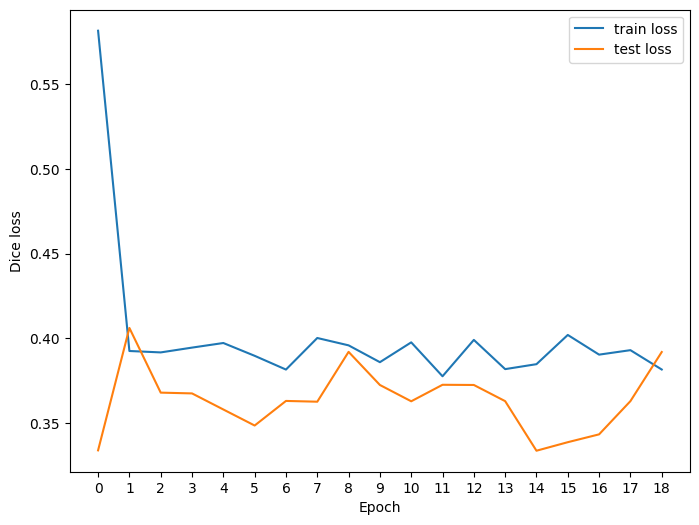

In [6]:
logs = pd.read_csv('model_logs.csv')
plt.figure(figsize=(8, 6))
plt.plot(logs['epoch'], logs['loss'], label='train loss')
plt.plot(logs['epoch'], logs['val_loss'], label='test loss')
plt.xticks(logs['epoch'])
plt.xlabel('Epoch')
plt.ylabel('Dice loss')
plt.legend()

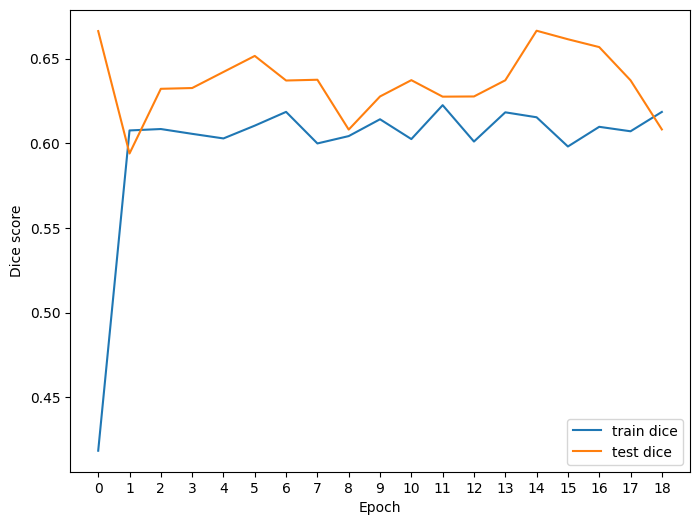

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(logs['epoch'], logs['dice_coef'], label='train dice')
plt.plot(logs['epoch'], logs['val_dice_coef'], label='test dice')
plt.xticks(logs['epoch'])
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.legend()

In [26]:
from skimage.io import imread
from keras.saving import load_model

img_path = '1c670582a.jpg'
img = imread(CONFIG['dirs']['data_imgs'] + '/' + img_path)

model = load_model('model.weights.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
result = model.predict(np.stack([img])/255.0)

1/1 [==============================] - 1s 650ms/step


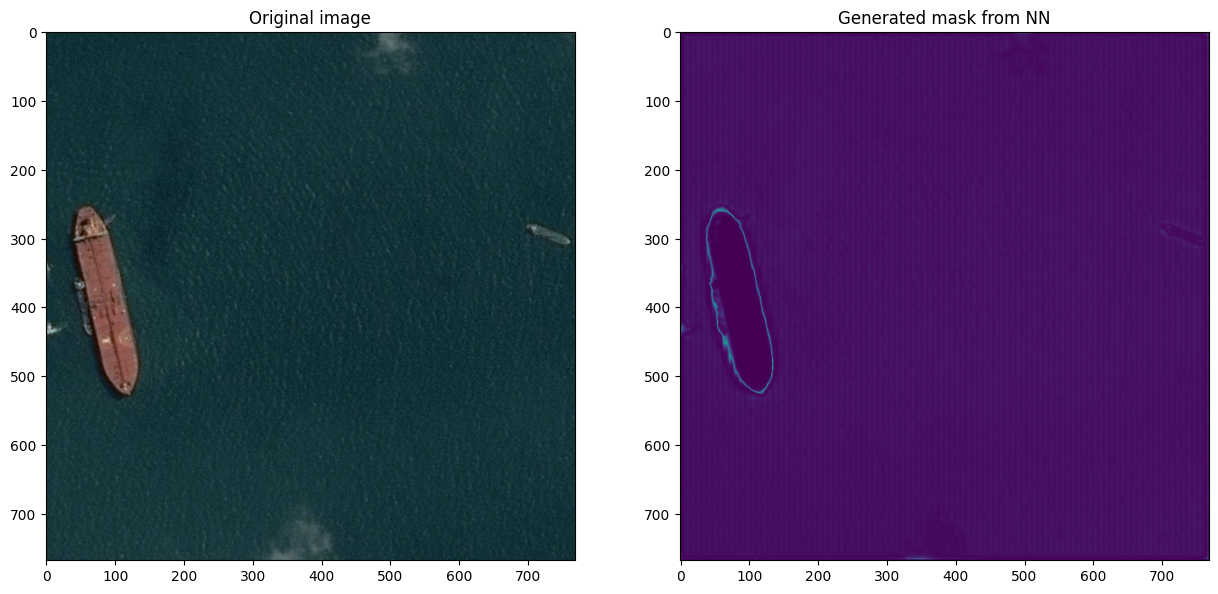

In [28]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.title('Original image')
plt.imshow(img)
plt.subplot(122)
plt.title('Generated mask from NN')
plt.imshow(result[0])

### Conclusions

- The dataset consists of jpg images of fixed 768x768x3 size, which mostly are blue and green pictures. 
- After training we end up with the dice score of about 0.61, which is pretty good, including the size of used dataset, which was decreased from 200k to 3500 pictures because of software limitations.
- Train/test loss plots showed that the training could be stoped after the first 5 epochs, where it got the minimum loss values.